# Vision AI + Data Science: Detecting Objects in Video

Data Science service uses [conda](https://anaconda.org/) environments to manage python dependencies.

[![Notebook Examples](https://img.shields.io/badge/docs-notebook--examples-blue)](https://github.com/oracle-samples/oci-data-science-ai-samples/tree/master/notebook_examples)
[![Conda Environments](https://img.shields.io/badge/docs-conda--environments-blue)](https://docs.oracle.com/en-us/iaas/data-science/using/conda_understand_environments.htm)
[![Source Code](https://img.shields.io/badge/source-accelerated--datascience-blue)](https://github.com/oracle/accelerated-data-science)

##### [Step-01] Libraries and Authentication and Access

<details>
<summary><font size="2">Install Pre-Requirements</font></summary>

```Install Libraries
!pip install opencv-python
!pip install tqdm
!pip install jupyterlab-widgets
```
</details>


In [1]:
import oci
import ads

import cv2
import os
import shutil
import base64
import re
import pandas as pd
from concurrent import futures
import glob
from IPython.display import Image, display, HTML
from tqdm import tqdm  # Importa tqdm para Jupyter Notebook

# Supported values: resource_principal, api_key
ads.set_auth("resource_principal") 
signer = oci.auth.signers.get_resource_principals_signer()

# Config
config = {'region': signer.region, 'tenancy': signer.tenancy_id}

##### [Step-02]  Bucket Using signer

Signer authentication was used [examples](https://github.com/oracle/oci-python-sdk/blob/master/examples/object_storage/object_storage_bulk_copy.py).

In [2]:
# Create the Object Storage client using the ADS signer
object_storage_client = oci.object_storage.ObjectStorageClient(config, signer=signer)

##### [Step-03] Get Object from Bucket and Downlod Object in Data Science

Use Object Storage and Archive Storage APIs to manage buckets, objects, and related resources. [examples](https://docs.oracle.com/en-us/iaas/tools/python-sdk-examples/2.125.1/objectstorage/get_object.py.html).

In [3]:
# [Function] Delete all files in the specified folder.
def fn_get_object(namespace, bucket_name, object_name):
    return object_storage_client.get_object(namespace, bucket_name, object_name)

In [4]:
# [Function] Download
def fn_download(object_content, local_video_path):
    # El contenido completo se considera un "chunk" en este caso
    content_size = len(object_content.data.content)
    with tqdm(total=content_size, desc="Processing | Downloading  ", unit=" MB", unit_scale=True) as pbar:
        with open(local_video_path, "wb") as f:
            f.write(object_content.data.content)
            pbar.update(content_size)

##### [Step-04] Clean Folder and Create Folder Local for Extract Images from Video

In [5]:
# [Function] Delete all files in the specified folder.
def fn_clean_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Error al borrar {file_path}. Razón: {e}')

# [Function] Create a folder if it doesn't exist or clear its contents if it already exists.
def fn_create_or_clean_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    else:
        fn_clean_folder(folder_path)

# Extract images from a video, one for each second of video, using a progress bar.
def save_frame(video_path, output_folder, frame_number, fps_rate):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        image_name = os.path.join(output_folder, f"image_{frame_number // fps_rate:09d}.jpg")
        cv2.imwrite(image_name, frame)
    cap.release()
    return ret

def fn_extract_images_from_parallel_video(video_path, output_folder, max_workers, fps_rate=None):
    cap = cv2.VideoCapture(video_path)
    if not fps_rate:
        fps_rate = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate which frames to save
    frames_to_save = range(0, total_frames, fps_rate)
    total_seconds = total_frames // fps_rate
    
    cap.release()
    
    # Run extraction in parallel
    with futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Create a progress bar with tqdm
        with tqdm(total=total_seconds, desc="Processing | Video Frames ", unit=" fps") as pbar:
            # Start saving frames in parallel
            future_to_frame = {
                executor.submit(save_frame, video_path, output_folder, frame_number, fps_rate): frame_number
                for frame_number in frames_to_save
            }
            for future in futures.as_completed(future_to_frame):
                pbar.update(1)
                if not future.result():
                    print(f"Failed to save frame {future_to_frame[future]}")

##### [Step-05] Vision Using signer

Signer authentication was used [examples](https://github.com/oracle/oci-python-sdk/blob/master/examples/object_storage/object_storage_bulk_copy.py).

In [6]:
# Create the Vision client using the ADS signer
vision_client = oci.ai_vision.AIServiceVisionClient(config, signer=signer)

##### [Step-06] Get Object Detection in OCI Vision AI

In [7]:
def fn_seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"

In [8]:
# [Function] OCI Vision AI
def fn_get_object_detection_vision(image_path, compartment_id, model_id):
    try:
        with open(image_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode("utf-8")

            analyze_image_response = vision_client.analyze_image(analyze_image_details = oci.ai_vision.models.AnalyzeImageDetails(
                                                                 compartment_id        = compartment_id,
                                                                 features              = [oci.ai_vision.models.ImageObjectDetectionFeature(max_results=1, model_id=model_id)],
                                                                 image                 = oci.ai_vision.models.InlineImageDetails(source="INLINE", data=encoded_string)))

            if analyze_image_response.data is not None and analyze_image_response.data.image_objects is not None:
                # Conteo de objetos detectados en la imagen
                n_cows = len(analyze_image_response.data.image_objects)
            else:
                n_cows = 0
            
            # Extraer el número de segundos del nombre del archivo
            seconds = int(re.search(r'(\d+)', image_path).group(0))
            time_format = fn_seconds_to_hms(seconds)
            
            return {'Path': image_path, 'Objects': n_cows, 'Detected': (1 if n_cows > 0 else 0), 'Seconds': seconds, 'Time': time_format}

    except FileNotFoundError:
        print(f"Archivo {image_path} no encontrado.")
        return {'Path': image_path, 'Objects': 0, 'Detected': 0, 'Seconds': None, 'Time': None}
    except Exception as e:
        print(f"Ocurrió un error al procesar la imagen {image_path}: {str(e)}")
        return {'Path': image_path, 'Objects': 0, 'Detected': 0, 'Seconds': None, 'Time': None}

In [9]:
def fn_process_all_images_parallel_vision(folder_path, compartment_id, model_id, max_workers):
    images = glob.glob(f"{folder_path}/*.jpg")

    # Run extraction in parallel
    with futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Use a dictionary to map futures to their image paths for easy identification
        future_to_image = {
            executor.submit(fn_get_object_detection_vision, image_path, compartment_id, model_id): image_path 
            for image_path in images
        }
        
        # Initialize an empty list for results
        results = []

        # Utilize tqdm for progress visualization
        for future in tqdm(futures.as_completed(future_to_image), total=len(future_to_image), desc="Processing | OCI Vision AI", unit=" img"):
            image_path = future_to_image[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                # Handle exceptions
                print(f"Image processing failed for {image_path}: {e}")
        
    # Create a DataFrame with the results
    return pd.DataFrame(results, columns=['Path', 'Objects', 'Detected', 'Seconds', 'Time']).sort_values(by='Seconds', ascending=True)

##### [Step-07] Data Visualization

In [10]:
def fn_get_duration(video_path):
    # Inicializar el objeto de captura de video
    cap = cv2.VideoCapture(video_path)

    # Obtener la cantidad total de frames
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    # Obtener el FPS del video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calcular la duración en segundos
    duration_seconds = total_frames / fps

    # Liberar el objeto de captura
    cap.release()

    return duration_seconds

In [11]:
from IPython.display import Markdown

def fn_get_result(df_results, local_video_path):
    # Sum all detected objects
    total_objects = len(df_results.loc[df_results['Objects'] != 0])
    
    # Convert object count in seconds to HH:MM:SS format
    total_time_hms = fn_seconds_to_hms(total_objects)

    # Duration
    duration = fn_get_duration(local_video_path)
    duration_hms = fn_seconds_to_hms(duration)
    
    # Get the start and end time of object detection
    start_time = df_results[df_results['Detected'] == 1]['Seconds'].min()
    end_time = df_results[df_results['Detected'] == 1]['Seconds'].max()

    # Get the last time an object was detected
    last_detection_time = df_results[df_results['Detected'] == 1]['Seconds'].max()

    # Convert start and end time to HH:MM:SS format
    start_time_hms = fn_seconds_to_hms(start_time)
    end_time_hms = fn_seconds_to_hms(last_detection_time)
    
   # Define the message with Markdown format
    markdown_message = f"""** 
    El video tiene una duración de {duration_hms} 🕑
    El logo de supermercados el rey se muestra desde el minuto {start_time_hms} hasta el minuto 00:11:00 👀**"""
    
    
    # Display message in Markdown
    display(Markdown(markdown_message))
    
    


In [12]:
def fn_get_time_segments(df_results):
    # Calculate changes in the 'Detected' column and form groups directly
    df_results['Group'] = (df_results['Detected'] != df_results['Detected'].shift()).cumsum()

    # Extracting the file name using operations on strings
    df_results['File'] = df_results['Path'].str.split('/').str[-1]

    # Group by 'Group' column and apply aggregation functions directly
    rs = df_results.groupby('Group').agg(
       # Objects     = ('Objects', 'sum'),    # Sum 'Objects'
        Start_Time  = ('Time', 'min'),       # Tiempo mínimo de 'Time'
        End_Time    = ('Time', 'max'),       # Tiempo máximo de 'Time'
        Start_Frame = ('File', 'min'),       # Nombre de archivo mínimo
        End_Frame   = ('File', 'max')        # Nombre de archivo máximo
    ).sort_index()

    # Print the resulting DataFrame
    with pd.option_context('display.max_rows', 1000):
        print(rs)    

In [13]:
def fn_get_image_base64(path):
    with open(path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode()

def fn_image_formatter(path):
    image_b64 = fn_get_image_base64(path)
    return f'<img src="data:image/jpeg;base64,{image_b64}" width="160">'

# Get Result in a List
def fn_get_resul_list(df_results):
    # Aplica la función para convertir las rutas de las imágenes a imágenes base64
    df_results['Frame'] = df_results['Path'].apply(fn_image_formatter)
    return HTML(df_results.head(10).to_html(escape=False))

##### [Step-08] Parameters

In [14]:
# Enter your Object storage: bucket namespace
namespace            = "idi1o0a010nx"
# Enter your Object storage: bucket name
bucket_name          = "DLK1LAG"
# Enter your Object storage: object name
object_name          = "movie/clip_tu_manana_cliente_rey.mp4"
# Enter your Local video path
local_video_path     = "tmp/movie.mp4"
# Enter your Local save path for Vision
images_folder_vision = "tmp/input_vision"
# Workers
max_workers          = os.cpu_count()

# Enter Compartment ID
compartment_id       = "ocid1.compartment.oc1..aaaaaaaavm4s2irzgacwxleaohzq2n5qxy6ynu2rxxgdkmd4m67l4omqjnna"
# Vision Model ID
model_id             = "ocid1.aivisionmodel.oc1.iad.amaaaaaafioir7iacpbbjd77y3ljfpbivmskdiyf7hpdks57wzmm54u57lka"

##### [Step-99] Processing

Processing | Downloading  : 100%|██████████| 863M/863M [00:15<00:00, 57.5M MB/s]
Processing | Video Frames : 100%|██████████| 1475/1475 [00:32<00:00, 44.82 fps/s]
Processing | OCI Vision AI: 100%|██████████| 1475/1475 [03:36<00:00,  6.81 img/s]


** 
    El video tiene una duración de 00:24:35 🕑
    El logo de supermercados el rey se muestra desde el minuto 00:00:02 hasta el minuto  00:11:00 👀**

      Start_Time  End_Time          Start_Frame            End_Frame
Group                                                               
1       00:00:00  00:00:01  image_000000000.jpg  image_000000001.jpg
2       00:00:02  00:01:51  image_000000002.jpg  image_000000111.jpg
3       00:01:52  00:01:53  image_000000112.jpg  image_000000113.jpg
4       00:01:54  00:11:00  image_000000114.jpg  image_000000660.jpg
5       00:11:01  00:11:06  image_000000661.jpg  image_000000666.jpg
6       00:11:07  00:11:08  image_000000667.jpg  image_000000668.jpg
7       00:11:09  00:11:14  image_000000669.jpg  image_000000674.jpg
8       00:11:15  00:11:15  image_000000675.jpg  image_000000675.jpg
9       00:11:16  00:11:22  image_000000676.jpg  image_000000682.jpg
10      00:11:23  00:11:23  image_000000683.jpg  image_000000683.jpg
11      00:11:24  00:11:24  image_000000684.jpg  image_000000684.jpg
12      00:11:25  00:11:26  image_000000685.jpg  image_000000686.jpg
13      00:11:27  00:11:34  image_

,Path,Objects,Detected,Seconds,Time,Group,File,Frame
337,tmp/input_vision/image_000000000.jpg,0,0,0,00:00:00,1,image_000000000.jpg,
1189,tmp/input_vision/image_000000001.jpg,0,0,1,00:00:01,1,image_000000001.jpg,
1196,tmp/input_vision/image_000000002.jpg,1,1,2,00:00:02,2,image_000000002.jpg,
220,tmp/input_vision/image_000000003.jpg,1,1,3,00:00:03,2,image_000000003.jpg,
486,tmp/input_vision/image_000000004.jpg,1,1,4,00:00:04,2,image_000000004.jpg,
373,tmp/input_vision/image_000000005.jpg,1,1,5,00:00:05,2,image_000000005.jpg,
1231,tmp/input_vision/image_000000006.jpg,1,1,6,00:00:06,2,image_000000006.jpg,
1275,tmp/input_vision/image_000000007.jpg,1,1,7,00:00:07,2,image_000000007.jpg,
1414,tmp/input_vision/image_000000008.jpg,1,1,8,00:00:08,2,image_000000008.jpg,
518,tmp/input_vision/image_000000009.jpg,1,1,9,00:00:09,2,image_000000009.jpg,

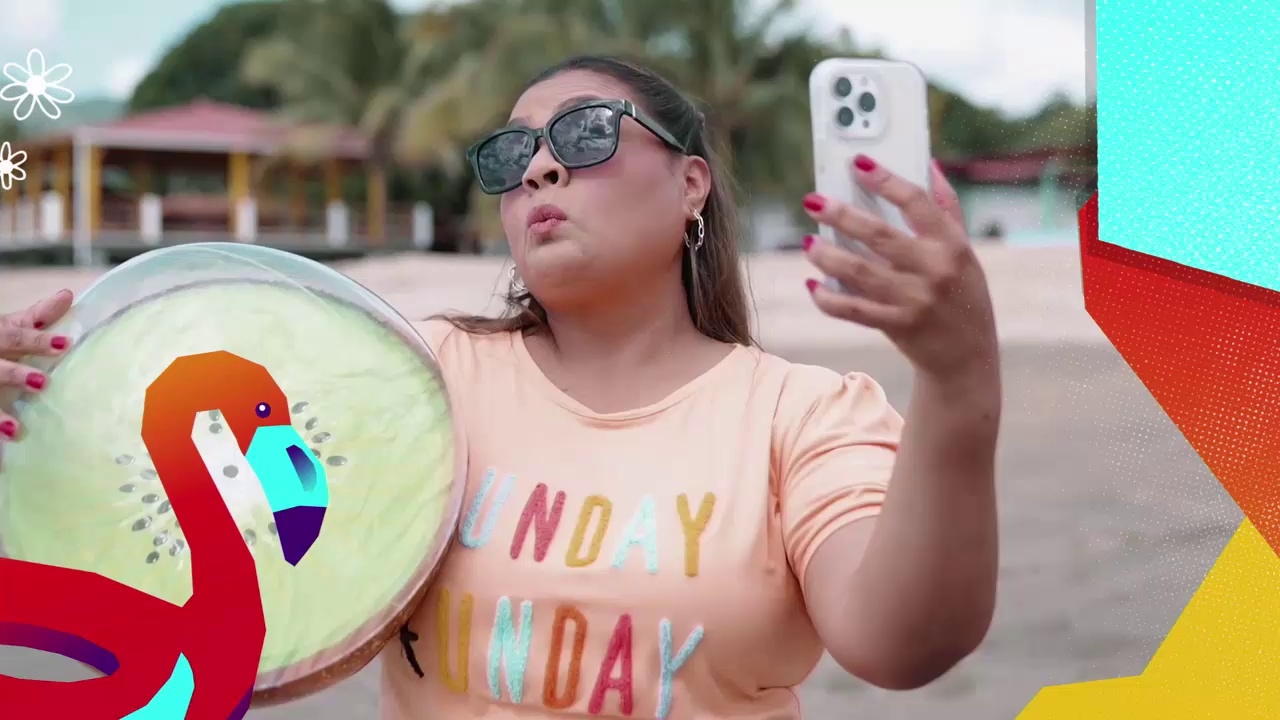
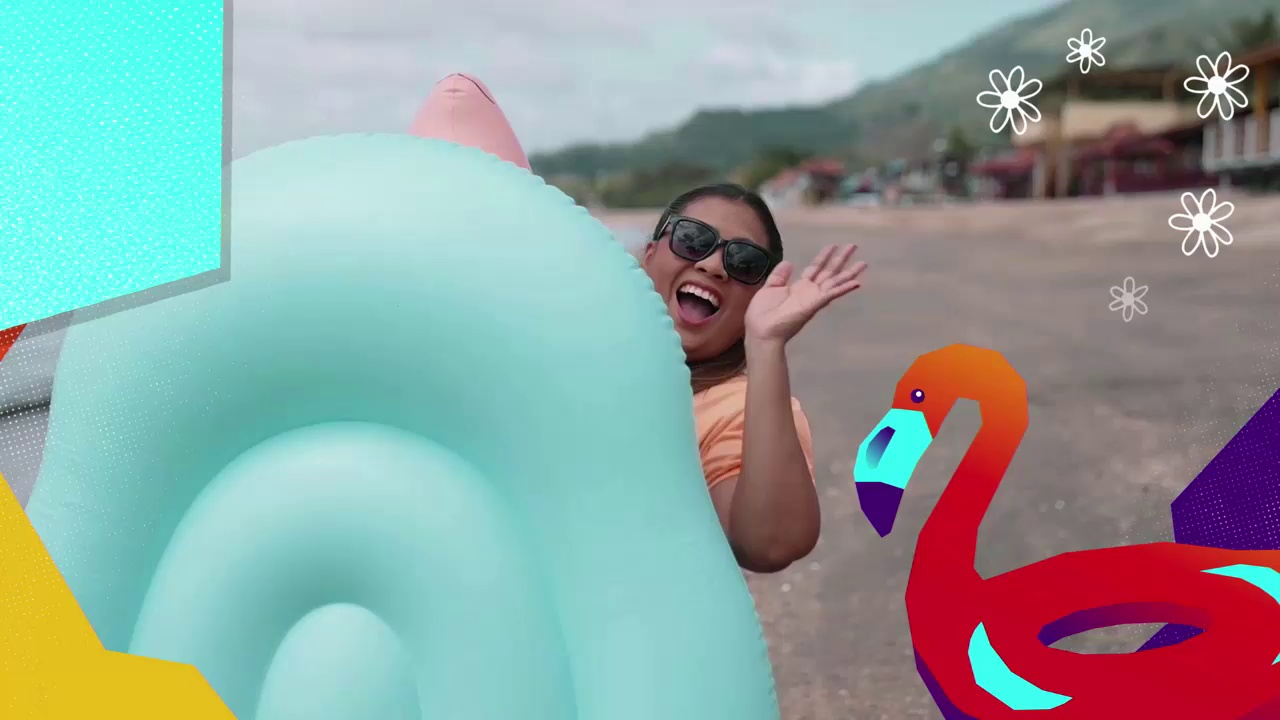
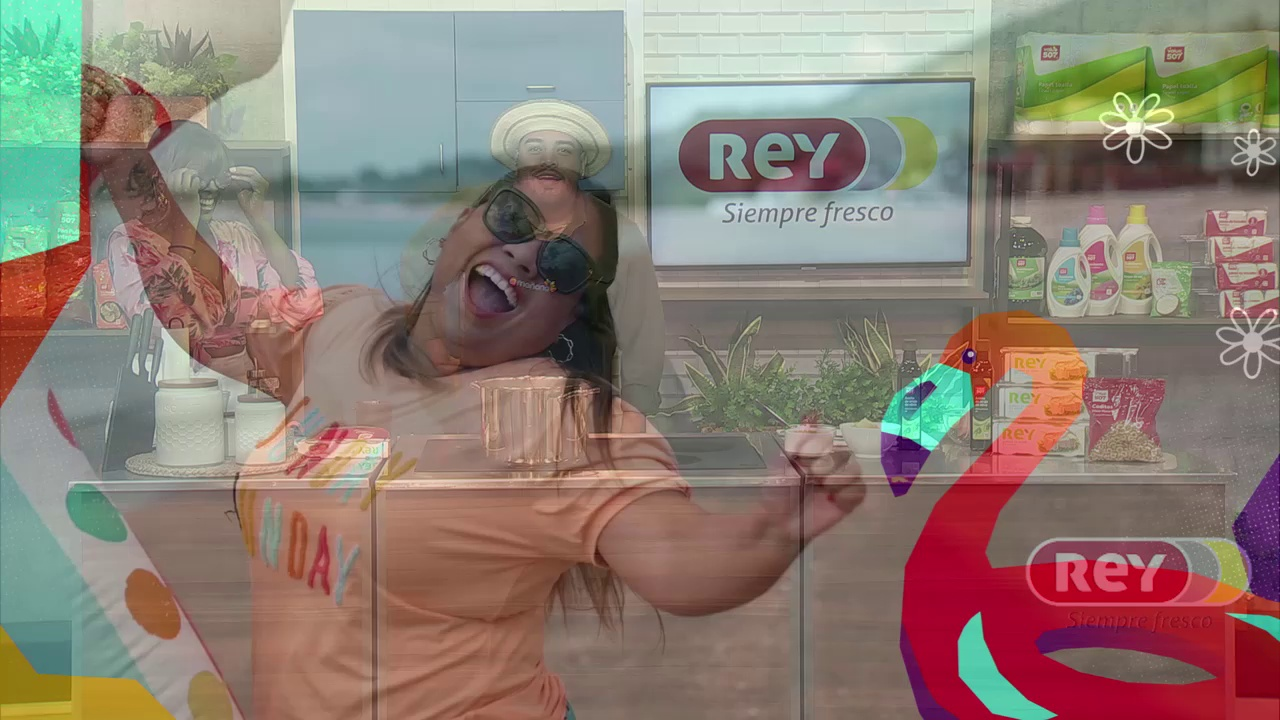
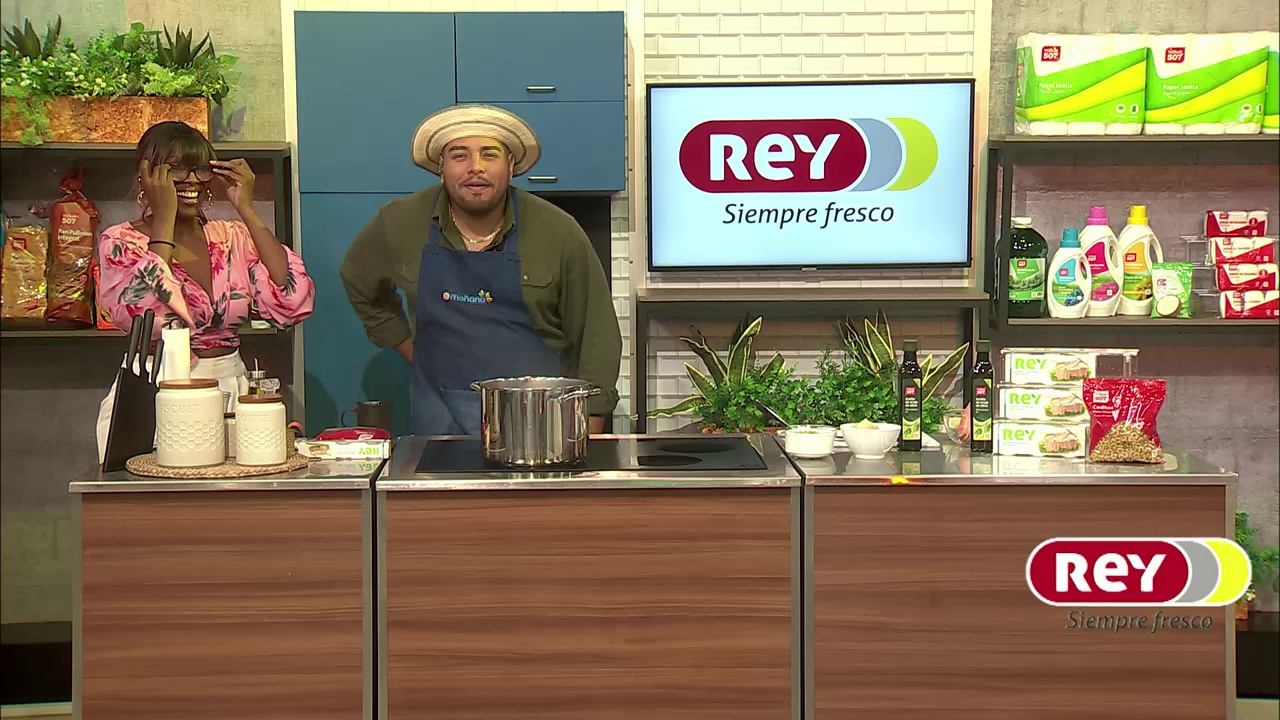
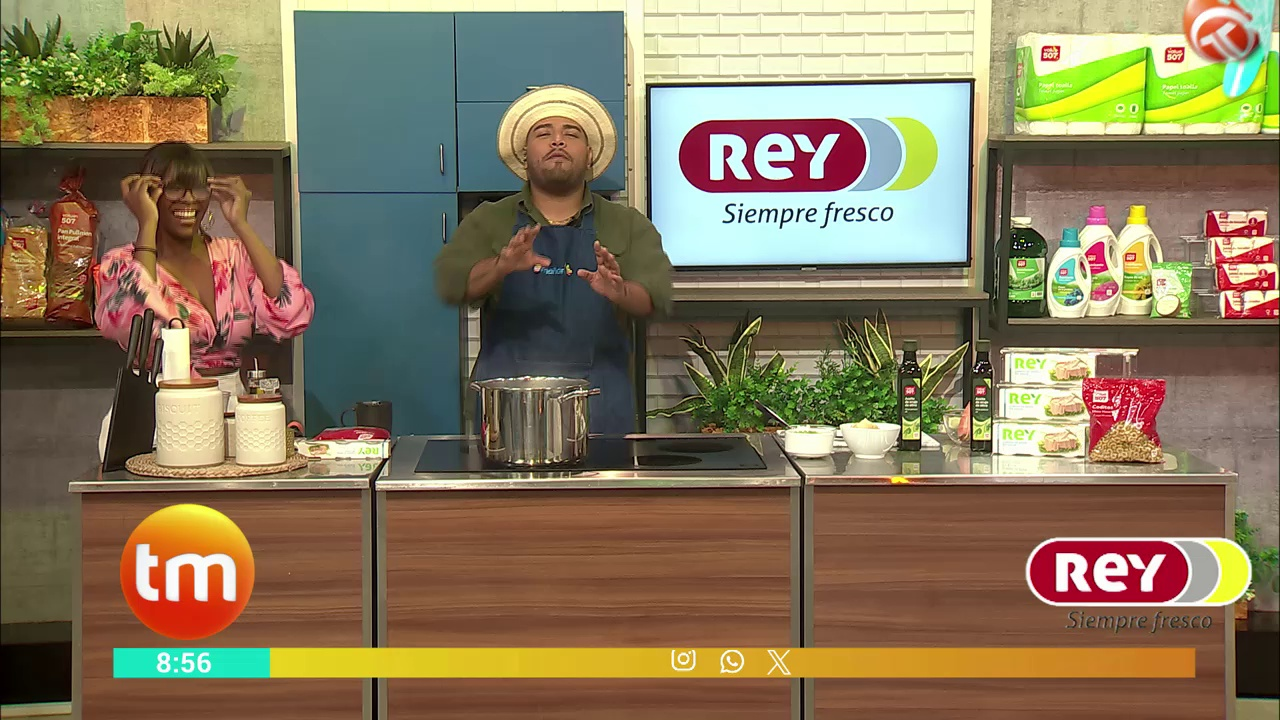
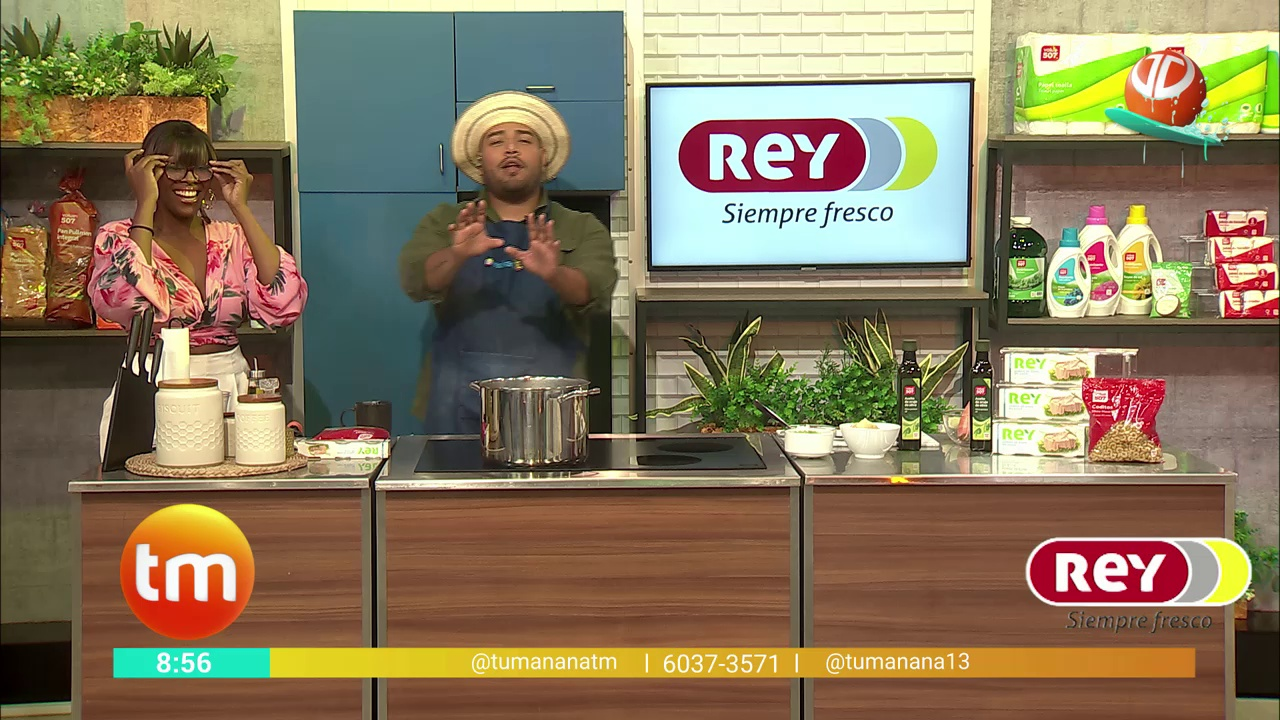
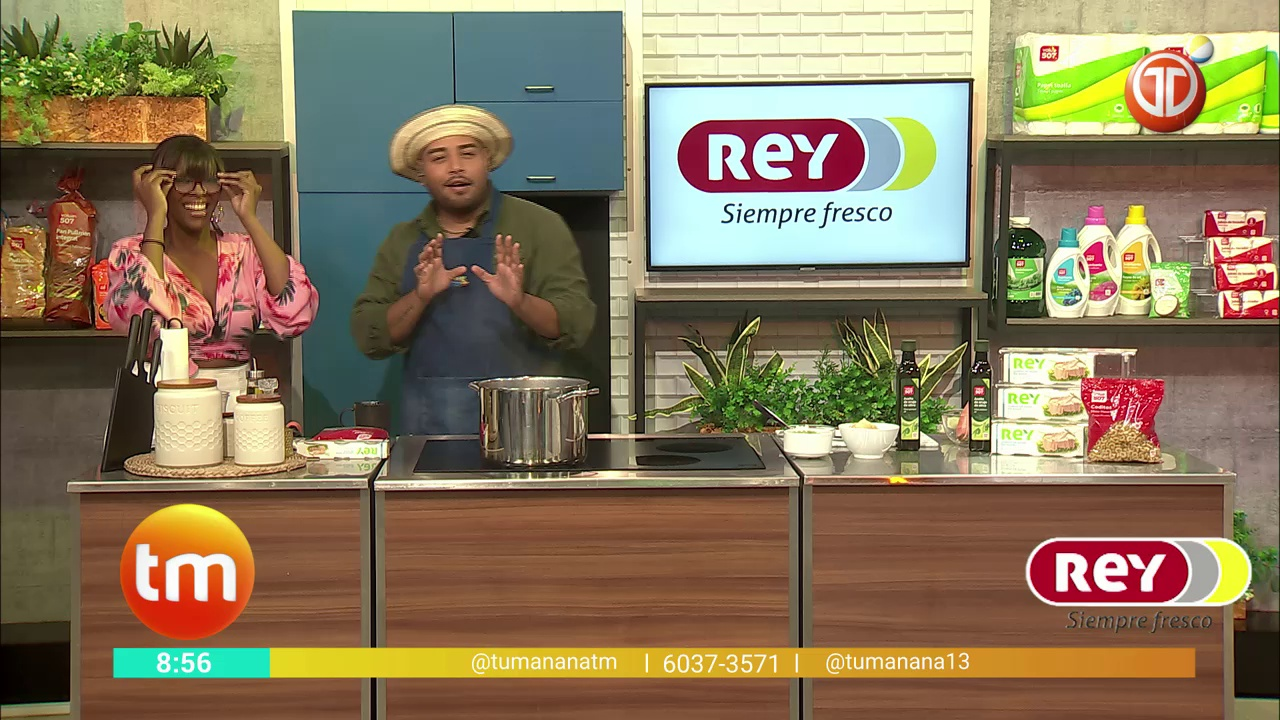
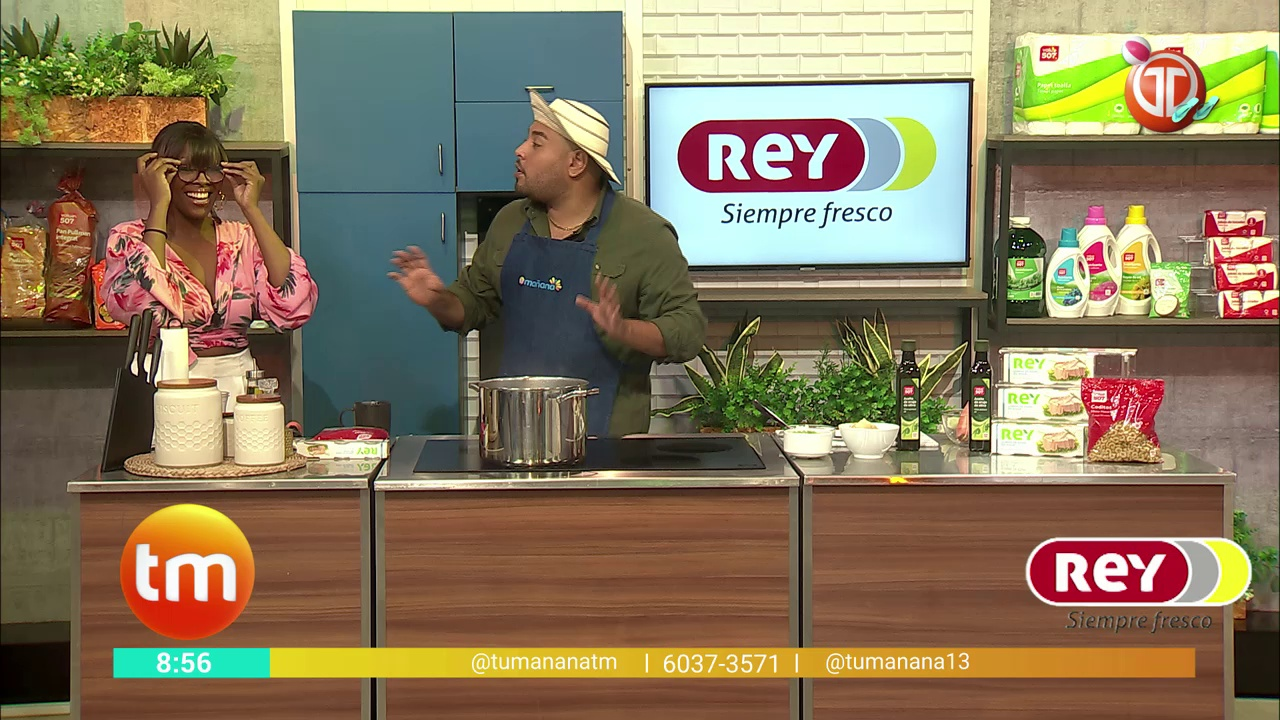
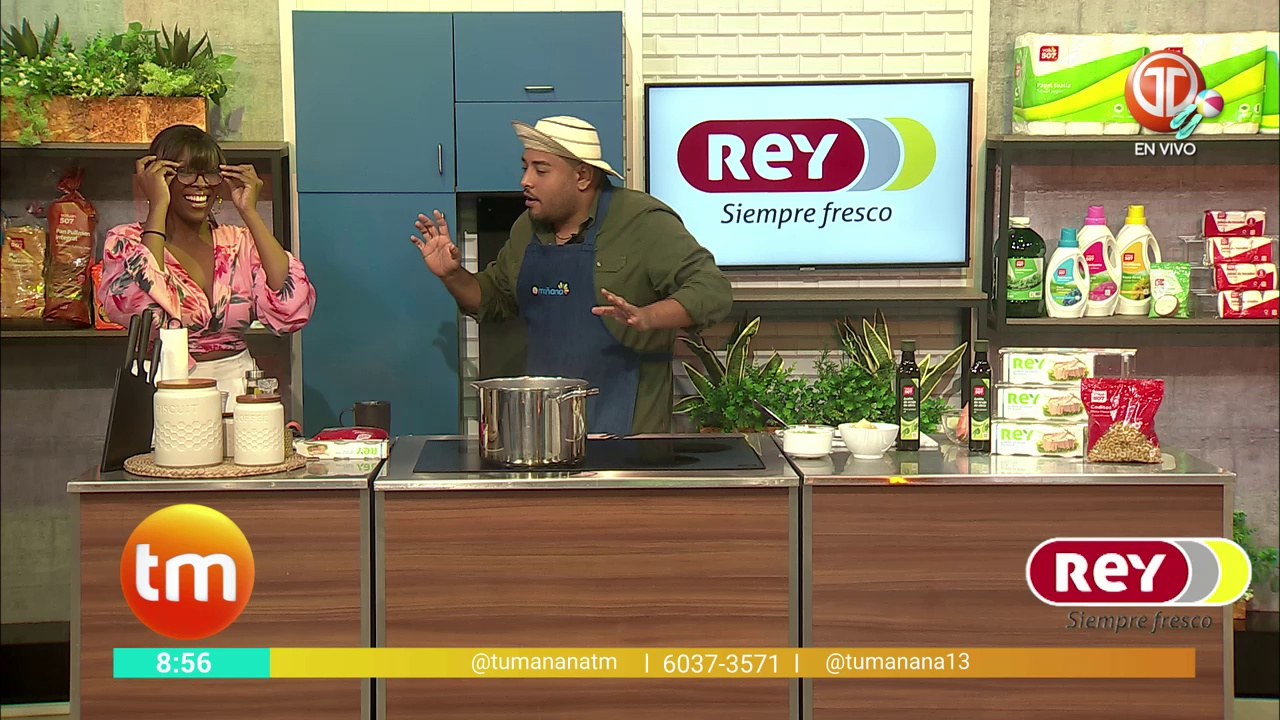
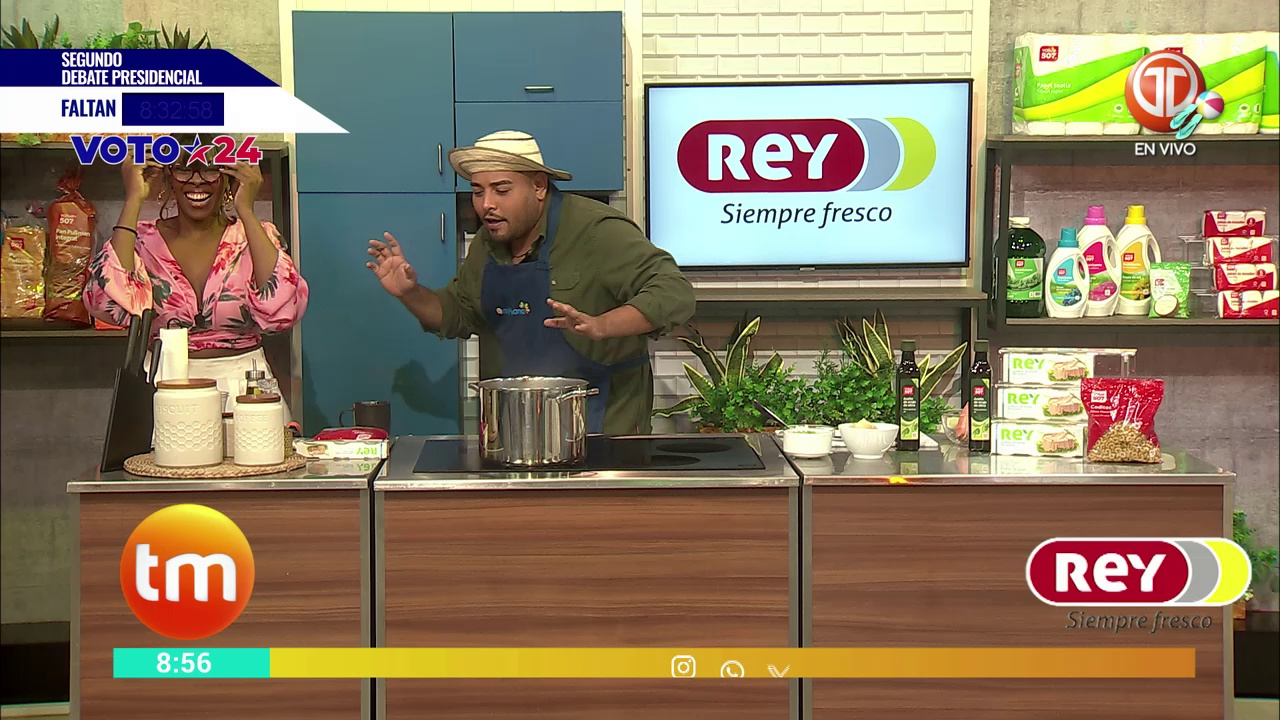

In [15]:
# Get Object
object_content = fn_get_object(namespace, bucket_name, object_name)

# Download
fn_download(object_content, local_video_path)

# Preparation
fn_create_or_clean_folder(images_folder_vision)

# Extract Images from Video
fn_extract_images_from_parallel_video(local_video_path, images_folder_vision, max_workers)

# Process All Images Parallel in Vision
df_results = fn_process_all_images_parallel_vision(images_folder_vision, compartment_id, model_id, max_workers/2)

# Data Visualization: Result
fn_get_result(df_results, local_video_path)

# Data Visualization: Time Segments
fn_get_time_segments(df_results)

# Data Visualization: Resul List
fn_get_resul_list(df_results)